In [22]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import preproccessing as prep
from evaluation import show_scenarios_evaluation
from regime_switching_brownian_motion import RegimeSwitching
from independent_lognormal_model import IndependentLogNormal
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
def convert_regime_params(params: pd.Series, k):
    """
    params: scipy stats regime params object
    k: number of regimes

    returns annulised params tumple (mean, sigma, transition matrix)
    """
    mu = np.zeros(k)
    sigmas = np.zeros(k)
    transition_matrix = np.zeros((k,k))
    
    for i in range (k):
        mu[i] = params[f'const[{i}]']
        sigmas[i] = np.sqrt(params[f'sigma2[{i}]'])
        
    for i in range(k):
        for j in range(k-1):
            transition_matrix[i,j] = params[f'p[{i}->{j}]']

    transition_matrix[:,-1] = 1 - transition_matrix.sum(axis=1)

            
    return mu, sigmas, transition_matrix

def params_summary(mus,sigmas,transition_matrix,current_regime):
    print('mus: ')
    print(mus * 12)
    print('sigmas: ')
    print(sigmas * np.sqrt(12))
    print('transition matrix: ')
    print(transition_matrix)
    print('current_regime: ')
    print(current_regime)

def estimate_markov_regime_switching_params(data,period):
    n_regimes = 2
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True
    )

    result = model.fit() 

    mus, sigmas, transition_matrix = convert_regime_params(result.params, n_regimes)

    current_regime = np.argmax([result.smoothed_marginal_probabilities[0].iloc[-1],result.smoothed_marginal_probabilities[1].iloc[-1]])

    #return {'mus':mus, 'sigmas': sigmas, 'transition_matrix': transition_matrix, 'current_regime': current_regime}
    return mus,sigmas,transition_matrix,current_regime

In [4]:
def show_RSLN_scenarios_evaluation(mus, sigmas, transition_matrix, initial_values, current_regime, dt, n_scenarios, n_steps, hist):
    
    model = RegimeSwitching(
    models=[IndependentLogNormal(mu=mus[0],sigma=[sigmas[0]]),
            IndependentLogNormal(mu=mus[1],sigma=[sigmas[1]])],
    probs=transition_matrix
    )

    scenarios = model.scenarios(initial_values,current_regime,dt,n_steps, n_scenarios)
    scenarios = pd.DataFrame(data=scenarios, index=range(n_scenarios), columns=range(n_steps+1))

    show_scenarios_evaluation(scenarios,hist)

def convert_to_transition_matrix(p00,p10):
     k =2
     transition_matrix = np.zeros((k,k))
     transition_matrix[0,0] = p00
     transition_matrix[1,0] = p10
     transition_matrix[:,1] = 1 - transition_matrix[:,0]
     return transition_matrix

In [40]:
#'acwi_25.08.23.csv' - curvo file
acwi = pd.read_excel('acwi_usd_net_31.11.23.xlsx',index_col='Date', parse_dates=True)
acwi = acwi.squeeze()
acwi = (acwi+1).cumprod()
acwi.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 430 entries, 1988-01-29 to 2023-10-31
Series name: ACWI
Non-Null Count  Dtype  
--------------  -----  
430 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


<AxesSubplot:xlabel='Date'>

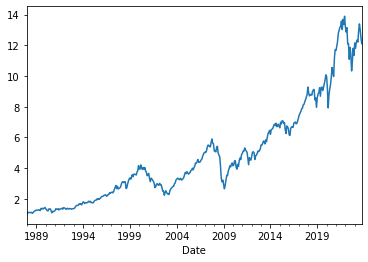

In [41]:
acwi.plot()

In [42]:
acwi_returns = prep.log_returns(acwi)

periods = [('1988-01-01', '2023-10-31'),
           ('2003-01-01', '2023-10-31'),
           ('1989-12-01', '2023-07-31'),
           ('1989-12-01', '2019-12-31'),
           ('2007-10-01', '2023-07-31'),               
           ('1999-01-01', '2023-10-31'), 
           ('2003-01-01', '2023-10-31'),                       
           ('2000-03-01', '2023-07-31'),
           ('2002-09-01', '2022-09-30'),
           ('2002-09-01', '2020-03-31'),
           ]
           

prep.asset_stats(acwi_returns, periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1988-01-01, 2023-10-31)",0.069067,0.153773,-0.785235,1.978242,0.880075,-0.549231
"(2003-01-01, 2023-10-31)",0.077396,0.156670,-0.939333,2.822137,1.047969,-0.549231
"(1989-12-01, 2023-07-31)",0.067090,0.155137,-0.827014,1.998269,0.828205,-0.549231
"(1989-12-01, 2019-12-31)",0.065635,0.150360,-0.888050,2.385491,0.820990,-0.549231
"(2007-10-01, 2023-07-31)",0.054167,0.171064,-0.873204,2.180193,0.489388,-0.549231
"(1999-01-01, 2023-10-31)",0.052303,0.159247,-0.801046,1.970217,0.485163,-0.549231
"(2003-01-01, 2023-10-31)",0.077396,0.156670,-0.939333,2.822137,1.047969,-0.549231
"(2000-03-01, 2023-07-31)",0.052099,0.160782,-0.833355,2.023188,0.476123,-0.549231
"(2002-09-01, 2022-09-30)",0.070303,0.159649,-0.976021,2.735161,0.874514,-0.549231
"(2002-09-01, 2020-03-31)",0.065229,0.156786,-1.138869,3.370436,0.778376,-0.549231


In [43]:

data = acwi_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    params.append(np.round(result.params * 100,2))

params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1988-01-01, 2023-10-31)",94.26,5.83,1.30,-0.16,0.06,0.32
"(2003-01-01, 2023-10-31)",94.15,6.88,1.35,-0.23,0.06,0.37
"(1989-12-01, 2023-07-31)",94.16,5.89,1.33,-0.23,0.06,0.33
"(1989-12-01, 2019-12-31)",95.33,5.27,1.29,-0.29,0.06,0.32
"(2007-10-01, 2023-07-31)",90.46,8.35,1.34,-0.33,0.05,0.40
"(1999-01-01, 2023-10-31)",94.65,4.47,1.35,-0.34,0.06,0.33
"(2003-01-01, 2023-10-31)",94.15,6.88,1.35,-0.23,0.06,0.37
"(2000-03-01, 2023-07-31)",94.53,4.82,1.38,-0.43,0.05,0.34
"(2002-09-01, 2022-09-30)",93.88,7.10,1.37,-0.43,0.05,0.40
"(2002-09-01, 2020-03-31)",94.27,8.13,1.34,-0.76,0.06,0.42


In [44]:
usdpln = prep.loadStooqData('usdpln','1998-12-01','d')
usdpln = usdpln.resample('BM').last()
usdpln_ret = prep.log_returns(usdpln)
acwi_pln = (acwi * usdpln).dropna()
acwi_pln_returns = prep.log_returns(acwi_pln)
prep.assets_performance(acwi_pln_returns['2000-01-01':])

Annualised Mean     0.045560
Annualised Sigma    0.131422
Skew               -0.474654
Kurtosis            0.605922
Sharp_ratio         0.410138
Max drowdawn       -0.501503
dtype: float64

<AxesSubplot:>

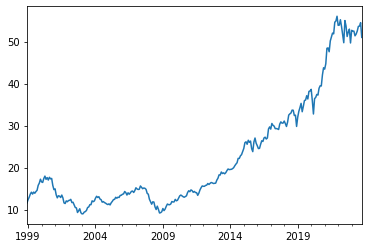

In [45]:
acwi_pln.plot()

<AxesSubplot:>

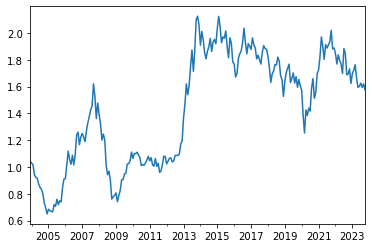

In [78]:
acwi_10y = (acwi_pln/acwi_pln.shift(60)).dropna()
acwi_10y.plot()


In [79]:
acwi_10y.describe()

count    239.000000
mean       1.432316
std        0.418508
min        0.649259
25%        1.043338
50%        1.555399
75%        1.812817
max        2.124944
dtype: float64

<AxesSubplot:>

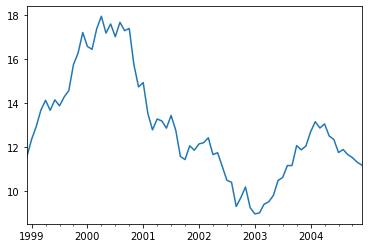

In [26]:
acwi_pln[:'2004-12-31'].plot()

In [80]:
periods = [('1999-01-01', '2023-10-31'), 
           ('1999-01-01', '2023-07-31'), 
           ('2003-01-01', '2023-10-31'),                       
           ('2000-03-01', '2023-07-31'),
           ('2002-09-01', '2022-09-30'),
           ('2002-09-01', '2020-03-31'),
           ]
prep.asset_stats(acwi_pln_returns, periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1999-01-01, 2023-10-31)",0.059710,0.132053,-0.479533,0.553699,0.779377,-0.501503
"(1999-01-01, 2023-07-31)",0.062362,0.131912,-0.480817,0.573809,0.849836,-0.501503
"(2003-01-01, 2023-10-31)",0.081994,0.121580,-0.293625,0.694741,1.481428,-0.412454
"(2000-03-01, 2023-07-31)",0.050466,0.131453,-0.487706,0.640260,0.539327,-0.501503
"(2002-09-01, 2022-09-30)",0.079423,0.126471,-0.428941,0.878068,1.353708,-0.412454
"(2002-09-01, 2020-03-31)",0.065291,0.124621,-0.637386,0.894812,0.980985,-0.412454


In [81]:
data = acwi_pln_returns
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    result.params['sigma2[0]'] = np.sqrt(result.params['sigma2[0]'])
    result.params['sigma2[1]'] = np.sqrt(result.params['sigma2[1]'])
    params.append(np.round(result.params * 100,2))


params_pln = pd.DataFrame(data=params, index=periods)
params_pln

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency BM will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1999-01-01, 2023-10-31)",95.48,10.99,1.26,-1.38,2.75,5.16
"(1999-01-01, 2023-07-31)",95.84,10.80,1.27,-1.36,2.74,5.18
"(2003-01-01, 2023-10-31)",95.75,13.79,1.13,-0.82,2.63,5.22
"(2000-03-01, 2023-07-31)",95.60,9.90,1.18,-1.28,2.63,5.17
"(2002-09-01, 2022-09-30)",95.77,12.04,1.18,-1.07,2.63,5.55
"(2002-09-01, 2020-03-31)",96.24,11.10,1.10,-1.53,2.60,5.50


In [29]:
params.mean(axis=0)

p[0->0]      95.768
p[1->0]      11.564
const[0]      1.170
const[1]     -1.216
sigma2[0]     2.648
sigma2[1]     5.320
dtype: float64

In [58]:
#'acwi_25.08.23.csv' - curvo file
acwi_curvo = pd.read_csv('acwi_25.08.23.csv',index_col='Date', parse_dates=True)
acwi_curvo = acwi_curvo.squeeze()
#acwi = (acwi+1).cumprod()
acwi_curvo.info()
acwi_curvo_ret = prep.log_returns(acwi_curvo)

<class 'pandas.core.series.Series'>
DatetimeIndex: 428 entries, 1987-12-01 to 2023-07-01
Series name: MSCI ACWI
Non-Null Count  Dtype  
--------------  -----  
428 non-null    float64
dtypes: float64(1)
memory usage: 6.7 KB


<AxesSubplot:xlabel='Date'>

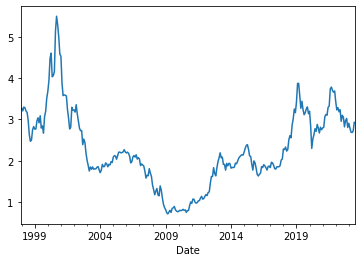

In [82]:
acwi_curvo_10 = (acwi_curvo/acwi_curvo.shift(120)).dropna()
acwi_curvo_10.plot()

In [83]:
acwi_curvo_10.describe()

count    308.000000
mean       2.283447
std        0.919249
min        0.710618
25%        1.797260
50%        2.105004
75%        2.938741
max        5.502399
Name: MSCI ACWI, dtype: float64

In [59]:
periods = [('1988-01-01', '2023-07-31'),
           ('1990-01-01', '2023-07-31'), 
           ('1999-01-01', '2023-07-31'), 
           ('2003-01-01', '2023-07-31'),                       
           ('2000-03-01', '2023-07-31'),
           ('2002-09-01', '2022-09-30'),
           ('2002-09-01', '2020-03-31'),
           ]
prep.asset_stats(acwi_curvo_ret, periods)

,Annualised Mean,Annualised Sigma,Skew,Kurtosis,Sharp_ratio,Max drowdawn
"(1988-01-01, 2023-07-31)",0.081733,0.149146,-0.752104,1.046907,1.201552,-0.532364
"(1990-01-01, 2023-07-31)",0.072948,0.150338,-0.752420,1.013315,0.989601,-0.532364
"(1999-01-01, 2023-07-31)",0.064579,0.147193,-0.667561,0.884257,0.813801,-0.532364
"(2003-01-01, 2023-07-31)",0.085973,0.133382,-0.687950,1.546646,1.453703,-0.481111
"(2000-03-01, 2023-07-31)",0.051727,0.146362,-0.707286,0.969489,0.514227,-0.532364
"(2002-09-01, 2022-09-30)",0.075865,0.139148,-0.741033,1.495476,1.141816,-0.481111
"(2002-09-01, 2020-03-31)",0.064281,0.138006,-0.922552,1.659685,0.860486,-0.481111


In [60]:
data = acwi_curvo_ret
n_regimes = 2
params = []

for period in periods:
    model = sm.tsa.MarkovRegression(
    data[period[0]:period[1]],
    k_regimes=n_regimes,
    switching_variance=True,
    freq=None
    )
    result = model.fit()
    result.params['sigma2[0]'] = np.sqrt(result.params['sigma2[0]'])
    result.params['sigma2[1]'] = np.sqrt(result.params['sigma2[1]'])
    params.append(np.round(result.params * 100,2))


params = pd.DataFrame(data=params, index=periods)
params

c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\matsz\miniconda3\envs\portfolio-optimisation\lib\si

,p[0->0],p[1->0],const[0],const[1],sigma2[0],sigma2[1]
"(1988-01-01, 2023-07-31)",93.49,9.16,1.60,-0.58,2.63,5.62
"(1990-01-01, 2023-07-31)",93.66,6.51,1.45,-0.26,2.42,5.54
"(1999-01-01, 2023-07-31)",94.03,7.14,1.36,-0.44,2.24,5.62
"(2003-01-01, 2023-07-31)",92.87,12.95,1.38,-0.52,2.21,5.54
"(2000-03-01, 2023-07-31)",93.90,8.55,1.38,-0.91,2.27,5.72
"(2002-09-01, 2022-09-30)",93.62,11.50,1.36,-0.84,2.29,5.88
"(2002-09-01, 2020-03-31)",94.30,11.45,1.32,-1.28,2.26,5.98


In [ ]:
p 1.5, 1, mu 0.2, -0.6, sig 0.4, -0.5

In [ ]:
95, 7.5, 1.39, -0.86, 2.8, 5.1

In [ ]:
def show_RSLN_scenarios_evaluation(mu1, mu2, sigma1, sigma2, p00,p10, initial_values, current_regime, dt, n_scenarios, n_steps, hist):

    transition_matrix = convert_to_transition_matrix(p00/100,p10/100)

    model = RegimeSwitching(
    models=[IndependentLogNormal(mu=mu1/100,sigma=sigma1/100),
            IndependentLogNormal(mu=mu2/100,sigma=sigma2/100)],
    probs=transition_matrix
    )

    scenarios = model.scenarios(initial_values,current_regime,dt,n_steps, n_scenarios)
    scenarios = pd.DataFrame(data=scenarios, index=range(n_scenarios), columns=range(n_steps+1))

    show_scenarios_evaluation(scenarios,hist)


interact_manual(show_RSLN_scenarios_evaluation,
         mu1=(0.5,5,0.01),
         mu2=(-3,3,0.01),
         sigma1=(1,7, 0.1),
         sigma2=(1,7, 0.1),
         p00 = (80,99,0.1),
         p10 = (1,20,0.1),
         initial_values=100,
         current_regime=0,
         dt=1,
         n_scenarios=2000,
         n_steps= 300,
         hist=fixed(acwi_pln_returns)
         )
        (1999-01-01, 2023-07-31)	95.84	10.80	1.27	-1.36	2.74	5.18

interactive(children=(FloatSlider(value=2.75, description='mu1', max=5.0, min=0.5, step=0.01), FloatSlider(val…

<function __main__.show_RSLN_scenarios_evaluation(mu1, mu2, sigma1, sigma2, p00, p10, initial_values, current_regime, dt, n_scenarios, n_steps, hist)>